In [3]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import pandas as pd
from parse import compile, parse
import mdtraj as mdt
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../../analysis")
from rdc import compute_rdc
from add_sidechains import add_sidechains


plt.rcParams['text.usetex'] = True
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage[version=4]{mhchem} \usepackage[separate-uncertainty=true,multi-part-units=single]{siunitx}"
sns.set_theme()

palette = sns.color_palette()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
exp_rdc = pd.read_csv(
    "ntailMV_rdc_nh_formartin.exp",
    sep=" ",
    header=None,
    index_col=0,
).squeeze()

Text(0, 0.5, '${}^1\\mathrm{D_{NH}}$ (\\unit{\\Hz})')

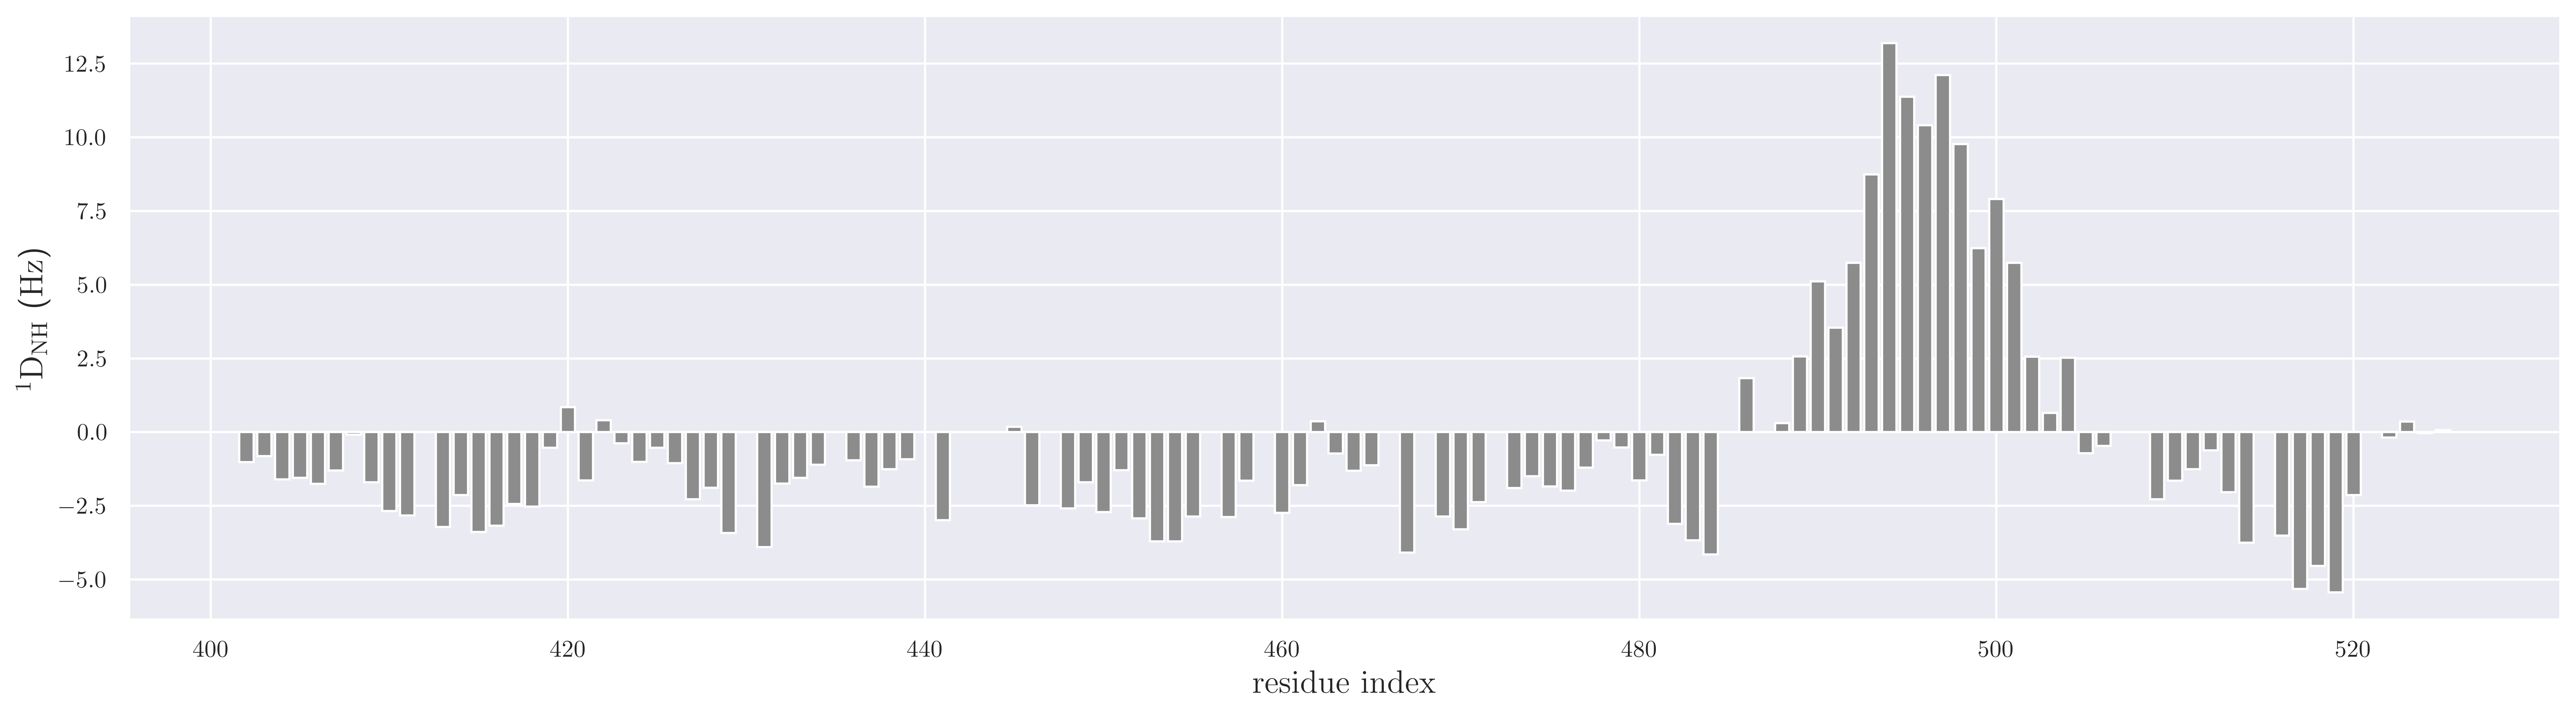

In [5]:
plt.figure(figsize=(20, 5), dpi=600)


plt.bar(exp_rdc.index, exp_rdc, color=palette[-3], label=r"\textrm{exp. data}")
plt.xlabel(r"\textrm{residue index}", fontsize=15)
plt.ylabel(r"${}^1\mathrm{D_{NH}}$ (\unit{\Hz})", fontsize=15)
# plt.legend()

In [16]:
from pathlib import Path
import subprocess


ens_path = "../../MeV_NT_ens"
cmd = rf'find {ens_path}/ensemble_200_1 -regex "^.*/[0-9]+a_132\.pdb$"'
res = subprocess.run(cmd, shell=True, capture_output=True, text=True)


pdbs = [Path(pdb) for pdb in res.stdout.splitlines()]
ens_trajs = add_sidechains(pdbs)

# ens_trajs = [mdt.load(pdb) for pdb in res.stdout.splitlines()]

res = compute_rdc(ens_trajs[:100], 15)
res.index += 401 - 8

In [3]:
ref_xtc = "/home/gzappavigna/traj/20241007_ff99sb-ildn-opc/md_nojump.xtc"
ref_pdb = "/home/gzappavigna/traj/20241007_ff99sb-ildn-opc/md_nojump.pdb"

ref_traj = mdt.load(ref_xtc, top=ref_pdb, stride=10)


cmap_xtc = "/home/gzappavigna/traj/20241015_ff99sb-ildn-opc_cmap/md_nojump.xtc"
cmap_pdb = "/home/gzappavigna/traj/20241015_ff99sb-ildn-opc_cmap/md_nojump.pdb"

cmap_traj = mdt.load(cmap_xtc, top=cmap_pdb, stride=10)

KeyboardInterrupt: 

In [4]:
period = 1000

one_every = round(period / ref_traj.timestep)
inds = np.arange(0, ref_traj.time.size, one_every)
ref_rdc_df = compute_rdc(ref_traj[inds], 15)


one_every = round(period / cmap_traj.timestep)
inds = np.arange(0, cmap_traj.time.size, one_every)
cmap_rdc_df = compute_rdc(cmap_traj[inds], 15)

In [5]:
ref_avg_rdc = ref_rdc_df.groupby("resSeq").mean().squeeze()
cmap_avg_rdc = cmap_rdc_df.groupby("resSeq").mean().squeeze()

In [6]:
ref_avg_rdc.index += 401 - 8
cmap_avg_rdc.index += 401 - 8

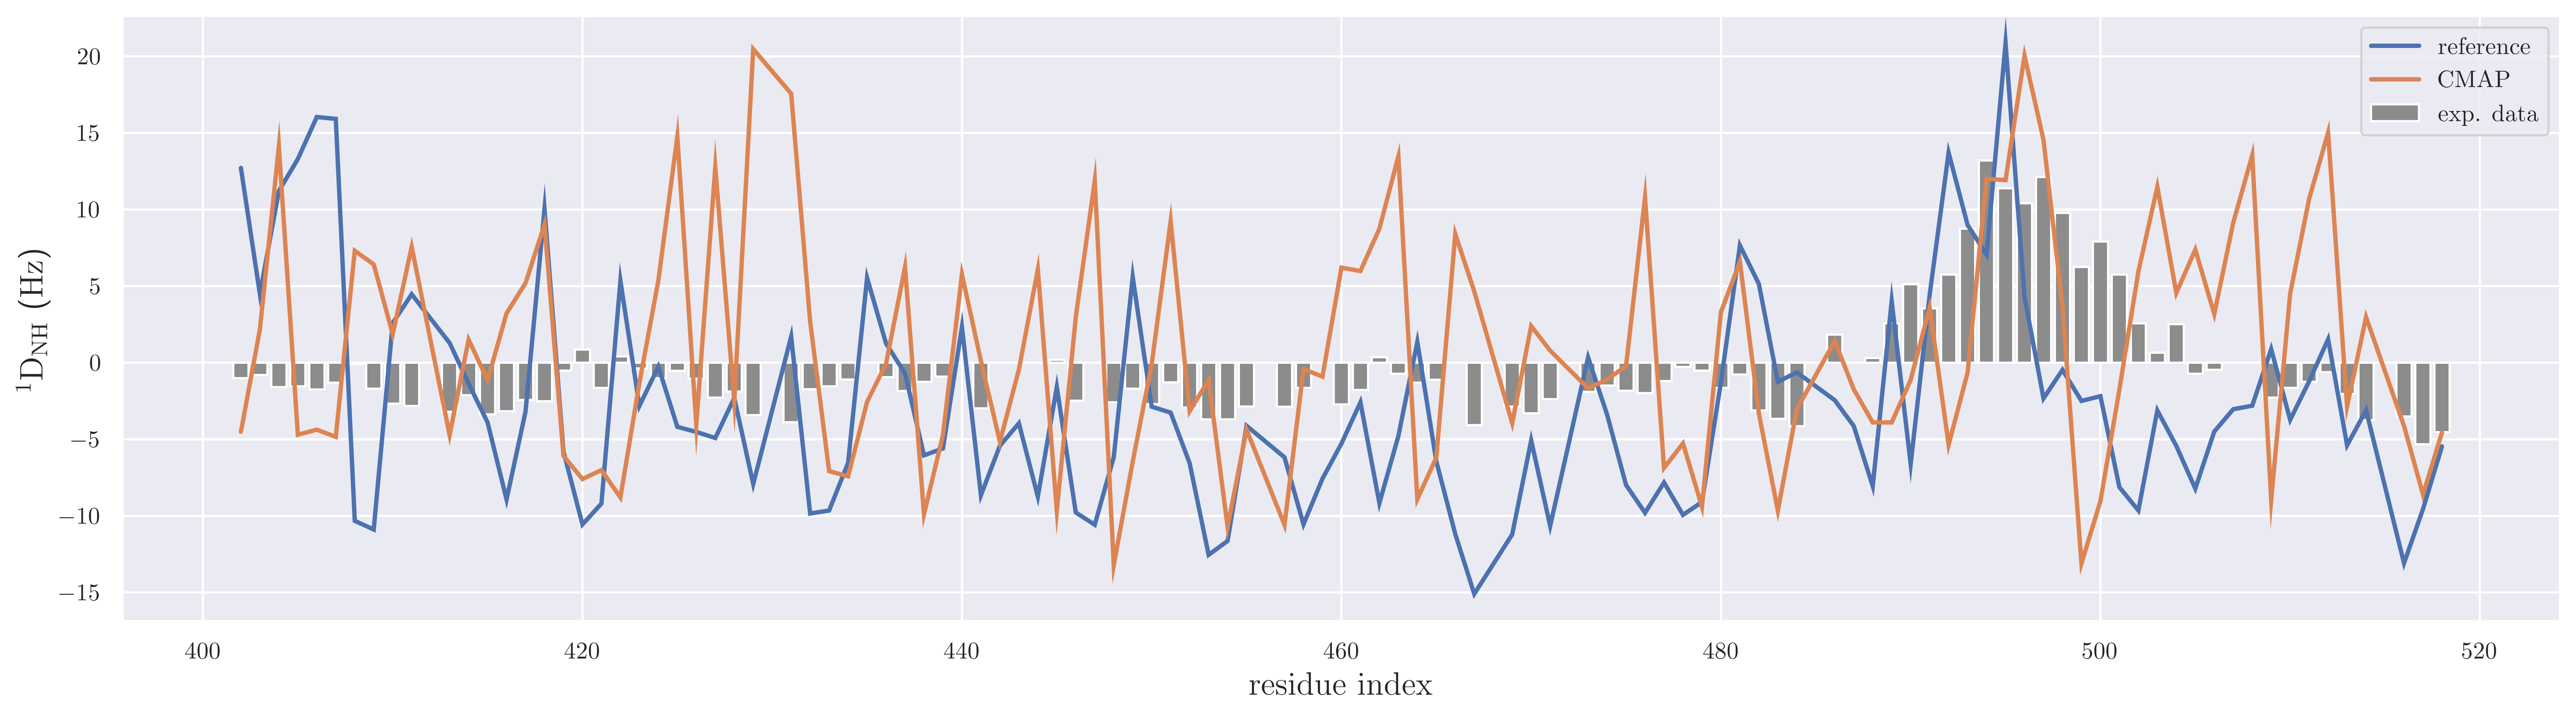

In [29]:
plt.figure(figsize=(20, 5), dpi=600)

start = max(exp_rdc.index.min(), ref_avg_rdc.index.min())
stop = min(exp_rdc.index.max(), ref_avg_rdc.index.max())

mask_f = lambda x: (start <= x.index) & (x.index <= stop)
sel_exp_rdc = exp_rdc[mask_f]
sel_ref_avg_rdc = ref_avg_rdc[mask_f]
sel_cmap_avg_rdc = cmap_avg_rdc[mask_f]

palette = sns.color_palette()
plt.bar(sel_exp_rdc.index, sel_exp_rdc, color=palette[-3], label=r"\textrm{exp. data}")
plt.plot(sel_ref_avg_rdc, lw=2, solid_joinstyle="miter", label=r"\textrm{reference}")
plt.plot(sel_cmap_avg_rdc, lw=2, solid_joinstyle="miter", label=r"\textrm{CMAP}")
plt.xlabel(r"\textrm{residue index}", fontsize=15)
plt.ylabel(r"${}^1\mathrm{D_{NH}}$ (\unit{\Hz})", fontsize=15)
plt.legend()

In [5]:
def compute_rdc_df(basedir, period=100):
    basedir = Path(basedir)

    xtcs = list(basedir.glob("*a_132/md_nojump.xtc"))
    pdbs = [xtc.with_suffix(".pdb") for xtc in xtcs]

    dfs = []

    for pdb, xtc in zip(pdbs, xtcs):
        conformer = parse("{:d}a_132", pdb.parent.name)[0]
        print(conformer)
        traj = mdt.load(xtc, top=pdb)

        one_every = round(period / traj.timestep)
        inds = np.arange(0, traj.time.size, one_every)
        subtraj = traj[inds]
        df = compute_rdc(subtraj, 15)
        df["conformer"] = conformer

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.set_index("conformer", append=True)

    return df


ref_rdc_df = compute_rdc_df("/home/gzappavigna/traj/20241018_ff99sb-ildn_opc_multidir")
cmap_rdc_df = compute_rdc_df(
    "/home/gzappavigna/traj/20241025_ff99sb-ildn_opc_cmap_multidir/"
)

3097
6811
4622
7057
13589
11199
14470
10440
14017
8104
15062
9802
13573
10717
1528
19517
9380
7982
9613
9510
12724
5970
7169
17425
11038
6591
4618
1120
14037
836
6125
13939
17396
11561
1313
10072
3125
5033
7576
1911
15070
3359
12973
14122
8523
3069
15809
6734
6235
5813
15996
11591
16074
11618
4070
1386
812
2504
9056
2292
12877
10498
5188
16179
724
7054
13162
16527
12088
13889
3075
8041
13609
10099
16258
14744
2938
8508
4492
11972
7719
4425
290
1220
10216
2923
10777
1340
927
12237
1532
5731
6921
873
15776
7753
3097
6811
4622
7057
13589
11199
14470
10440
14017
8104
15062
9802
13573
10717
1528
19517
9380
7982
9613
9510
12724
5970
7169
17425
11038
6591
4618
1120
14037
836
6125
13939
17396
11561
1313
10072
3125
5033
7576
1911
15070
3359
12973
14122
8523
3069
15809
6734
6235
5813
15996
11591
16074
11618
4070
1386
812
2504
9056
2292
12877
10498
5188
16179
724
7054
13162
16527
12088
13889
3075
8041
13609
10099
16258
14744
2938
8508
4492
11972
7719
4425
290
1220
10216
2923
10777
1340
927
12237


In [8]:
ref_rdc_df.to_csv("ref_rdc_df.csv")
cmap_rdc_df.to_csv("cmap_rdc_df.csv")

In [18]:
ref_rdc_df.to_pickle("ref_rdc_df.pkl")
cmap_rdc_df.to_pickle("cmap_rdc_df.pkl")

In [5]:
ref_rdc_df = pd.read_csv("ref_rdc_df.csv", index_col=["frame", "resSeq", "conformer"])
cmap_rdc_df = pd.read_csv("cmap_rdc_df.csv", index_col=["frame", "resSeq", "conformer"])

In [6]:
idx = ref_rdc_df.index.names.index("resSeq")
ref_rdc_df.index = ref_rdc_df.index.set_levels(
    ref_rdc_df.index.levels[idx] + 401 - 8, level=idx
)

idx = cmap_rdc_df.index.names.index("resSeq")
cmap_rdc_df.index = cmap_rdc_df.index.set_levels(
    cmap_rdc_df.index.levels[idx] + 401 - 8, level=idx
)

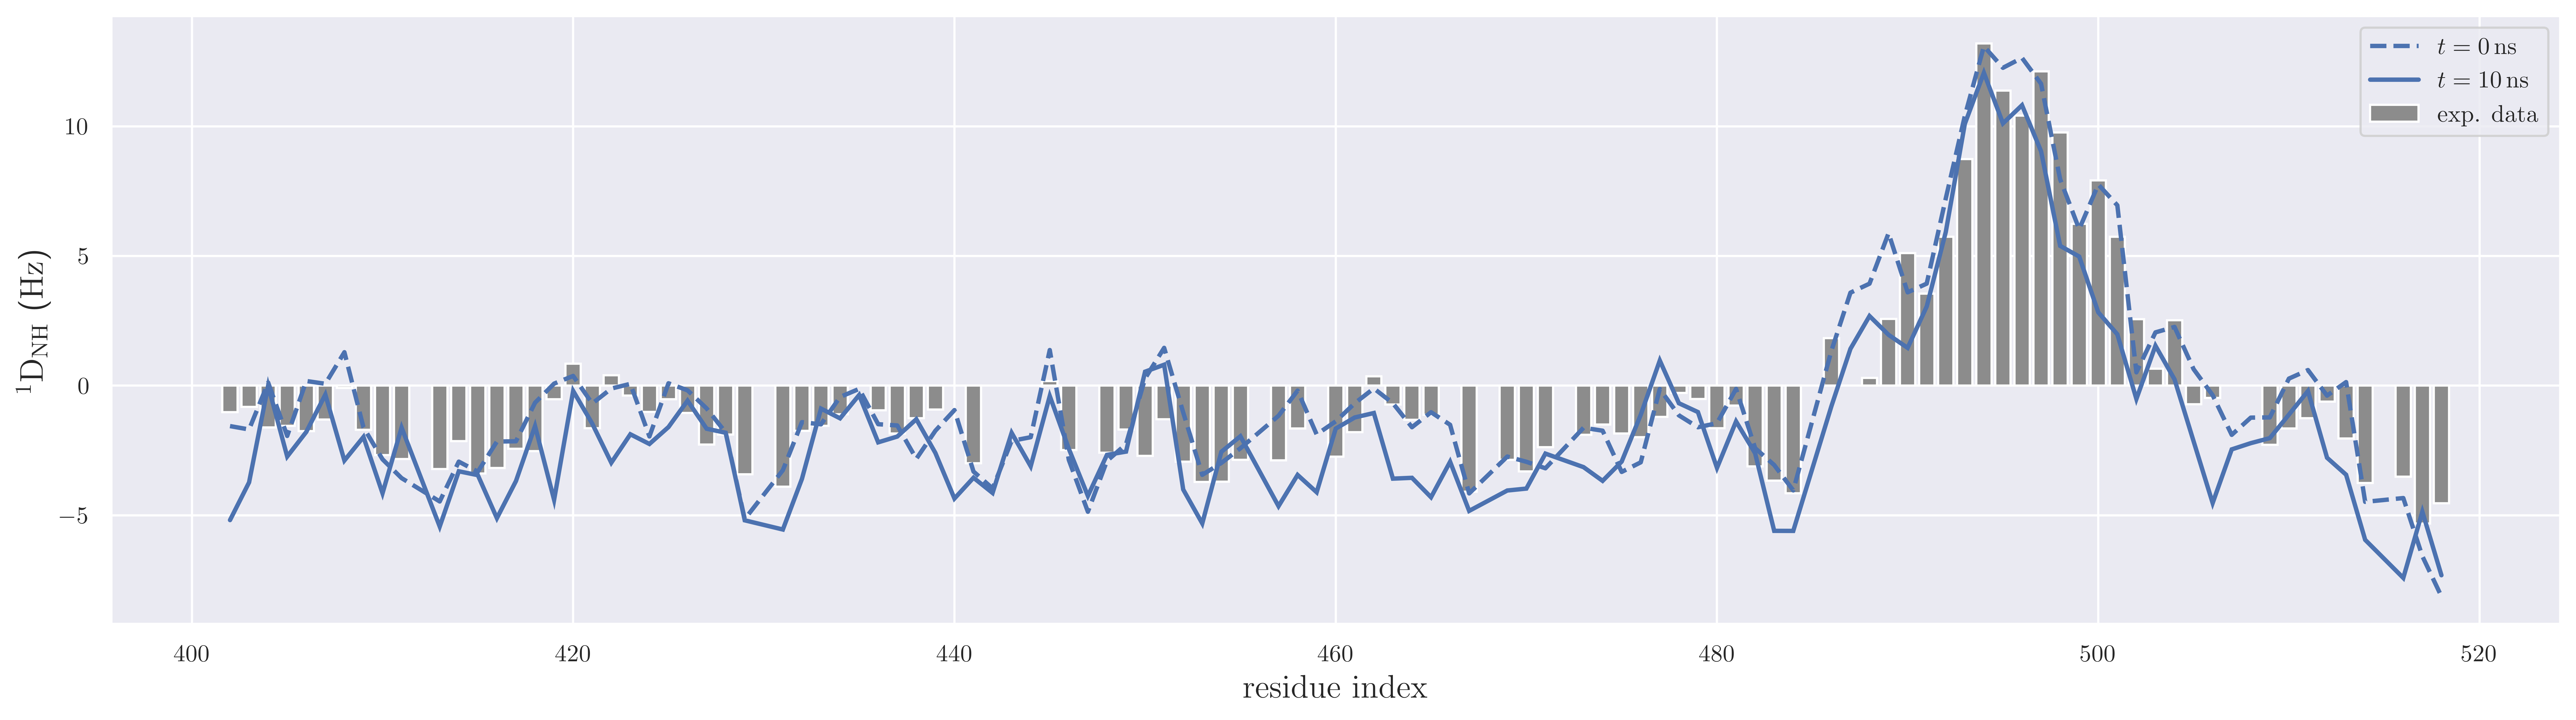

In [7]:
ref_avg_rdc = ref_rdc_df.groupby(["resSeq", "frame"])["value"].mean()

start = max(exp_rdc.index.min(), ref_avg_rdc.index.get_level_values("resSeq").min())
stop = min(exp_rdc.index.max(), ref_avg_rdc.index.get_level_values("resSeq").max())

mask_f = lambda x: (start <= x.index) & (x.index <= stop)
sel_exp_rdc = exp_rdc[mask_f]

idx = ref_avg_rdc.index.names.index("resSeq")
mask_f = lambda x: (start <= x.index.get_level_values("resSeq")) & (x.index.get_level_values("resSeq") <= stop)
sel_ref_avg_rdc = ref_avg_rdc[mask_f]


plt.figure(figsize=(20, 5), dpi=600)
palette = sns.color_palette()
plt.bar(sel_exp_rdc.index, sel_exp_rdc, color=palette[-3], label=r"\textrm{exp. data}")

plt.plot(sel_ref_avg_rdc.xs(0, level="frame"), lw=2,ls="--", color=palette[0], solid_joinstyle="miter", label=r"$t=\qty{0}{\ns}$")
plt.plot(sel_ref_avg_rdc.xs(100, level="frame"), lw=2, color=palette[0], solid_joinstyle="miter", label=r"$t=\qty{10}{\ns}$")

plt.xlabel(r"\textrm{residue index}", fontsize=15)
plt.ylabel(r"${}^1\mathrm{D_{NH}}$ (\unit{\Hz})", fontsize=15)
plt.legend()


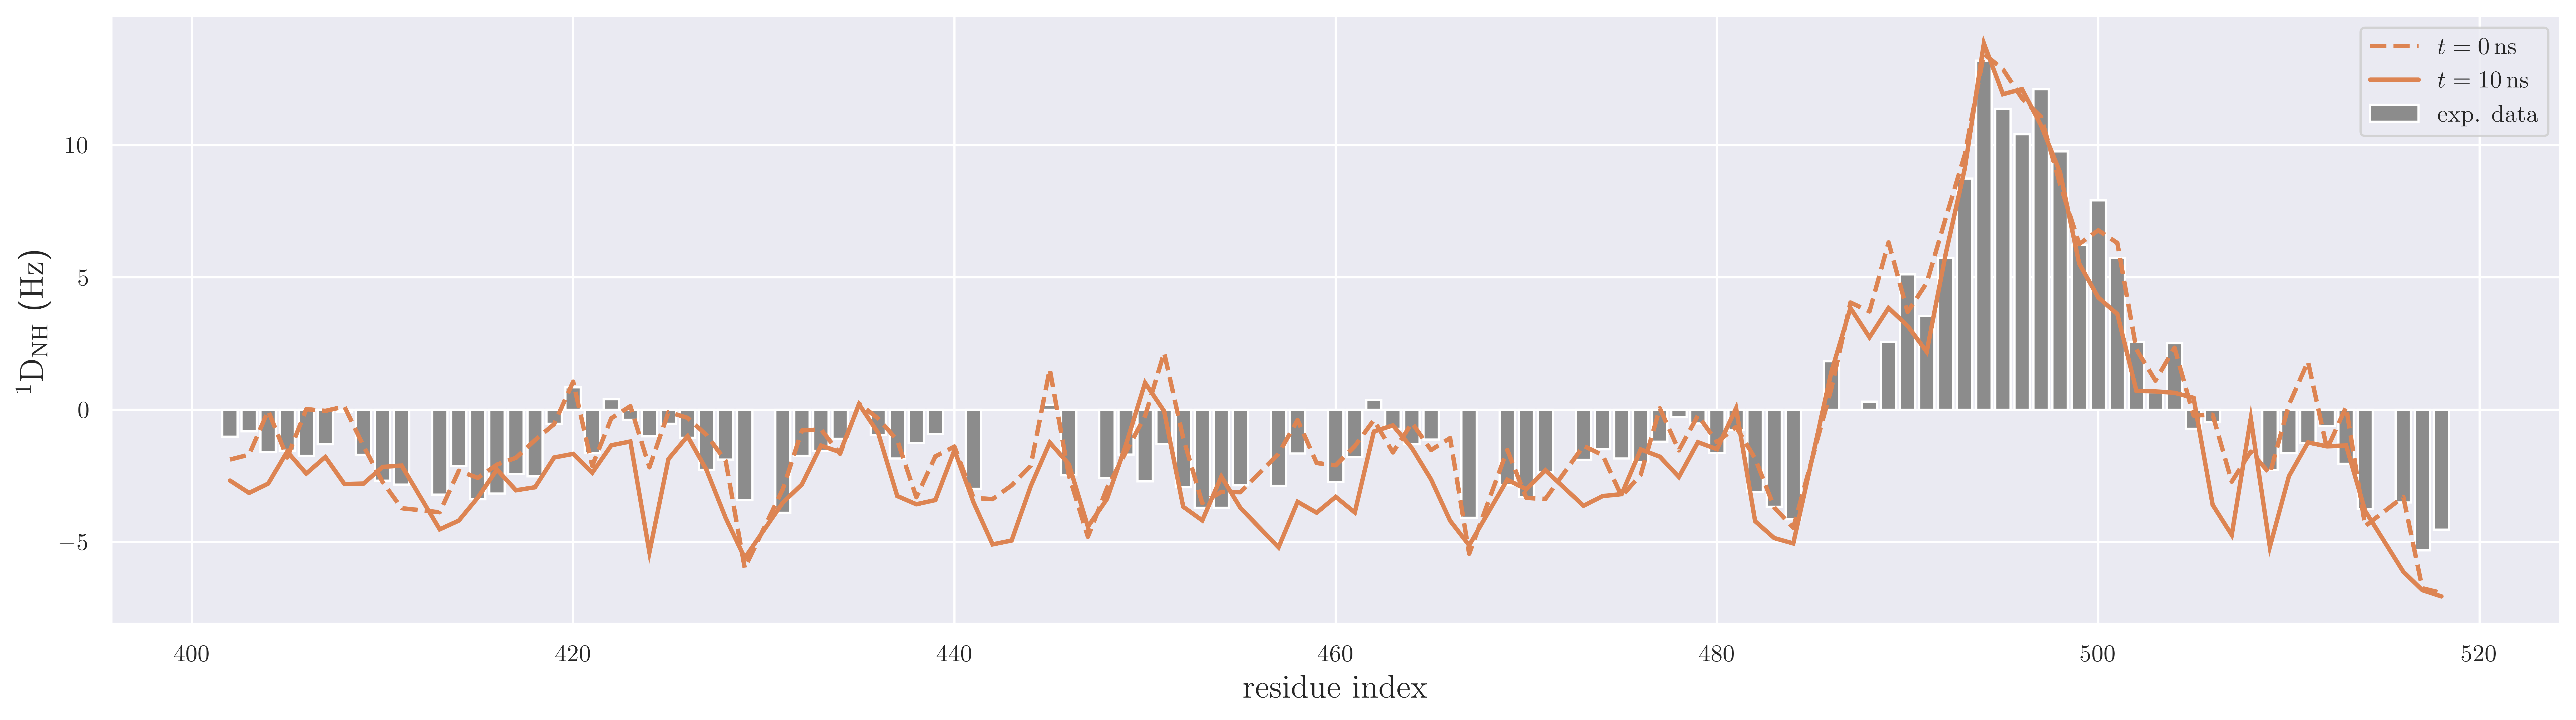

In [53]:
cmap_avg_rdc = cmap_rdc_df.groupby(["resSeq", "frame"])["value"].mean()

start = max(exp_rdc.index.min(), cmap_avg_rdc.index.get_level_values("resSeq").min())
stop = min(exp_rdc.index.max(), cmap_avg_rdc.index.get_level_values("resSeq").max())

mask_f = lambda x: (start <= x.index) & (x.index <= stop)
sel_exp_rdc = exp_rdc[mask_f]

idx = cmap_avg_rdc.index.names.index("resSeq")
mask_f = lambda x: (start <= x.index.get_level_values("resSeq")) & (x.index.get_level_values("resSeq") <= stop)
sel_cmap_avg_rdc = cmap_avg_rdc[mask_f]


plt.figure(figsize=(20, 5), dpi=600)
palette = sns.color_palette()
plt.bar(sel_exp_rdc.index, sel_exp_rdc, color=palette[-3], label=r"\textrm{exp. data}")

plt.plot(sel_cmap_avg_rdc.xs(0, level="frame"), lw=2,ls="--", color=palette[1], solid_joinstyle="miter", label=r"$t=\qty{0}{\ns}$")
plt.plot(sel_cmap_avg_rdc.xs(100, level="frame"), lw=2, color=palette[1], solid_joinstyle="miter", label=r"$t=\qty{10}{\ns}$")

plt.xlabel(r"\textrm{residue index}", fontsize=15)
plt.ylabel(r"${}^1\mathrm{D_{NH}}$ (\unit{\Hz})", fontsize=15)
plt.legend()


In [8]:
def avg_rdc_rmsd(rdc_df, exp_rdc):
    grouper = rdc_df.groupby(["resSeq", "frame"])["value"]
    avg_rdc = grouper.mean()
    err = grouper.std() / np.sqrt(grouper.count())

    rmsd_list = []
    sigma_list = []

    for i in range(100 + 1):

        sim_rdc = avg_rdc.xs(i, level="frame")
        rdc_sigma2 = err.xs(i, level="frame") ** 2

        sd = (sim_rdc - exp_rdc) ** 2
        mask = sd.notna()

        sd = sd[mask]
        rdc_sigma2 = rdc_sigma2[mask]

        rmsd = np.sqrt(np.mean(sd))

        sigma = np.sqrt(np.sum(sd * rdc_sigma2)) / (sd.count() * rmsd)
        rmsd_list.append(rmsd)
        sigma_list.append(sigma)

    return np.array(rmsd_list), np.array(sigma_list)

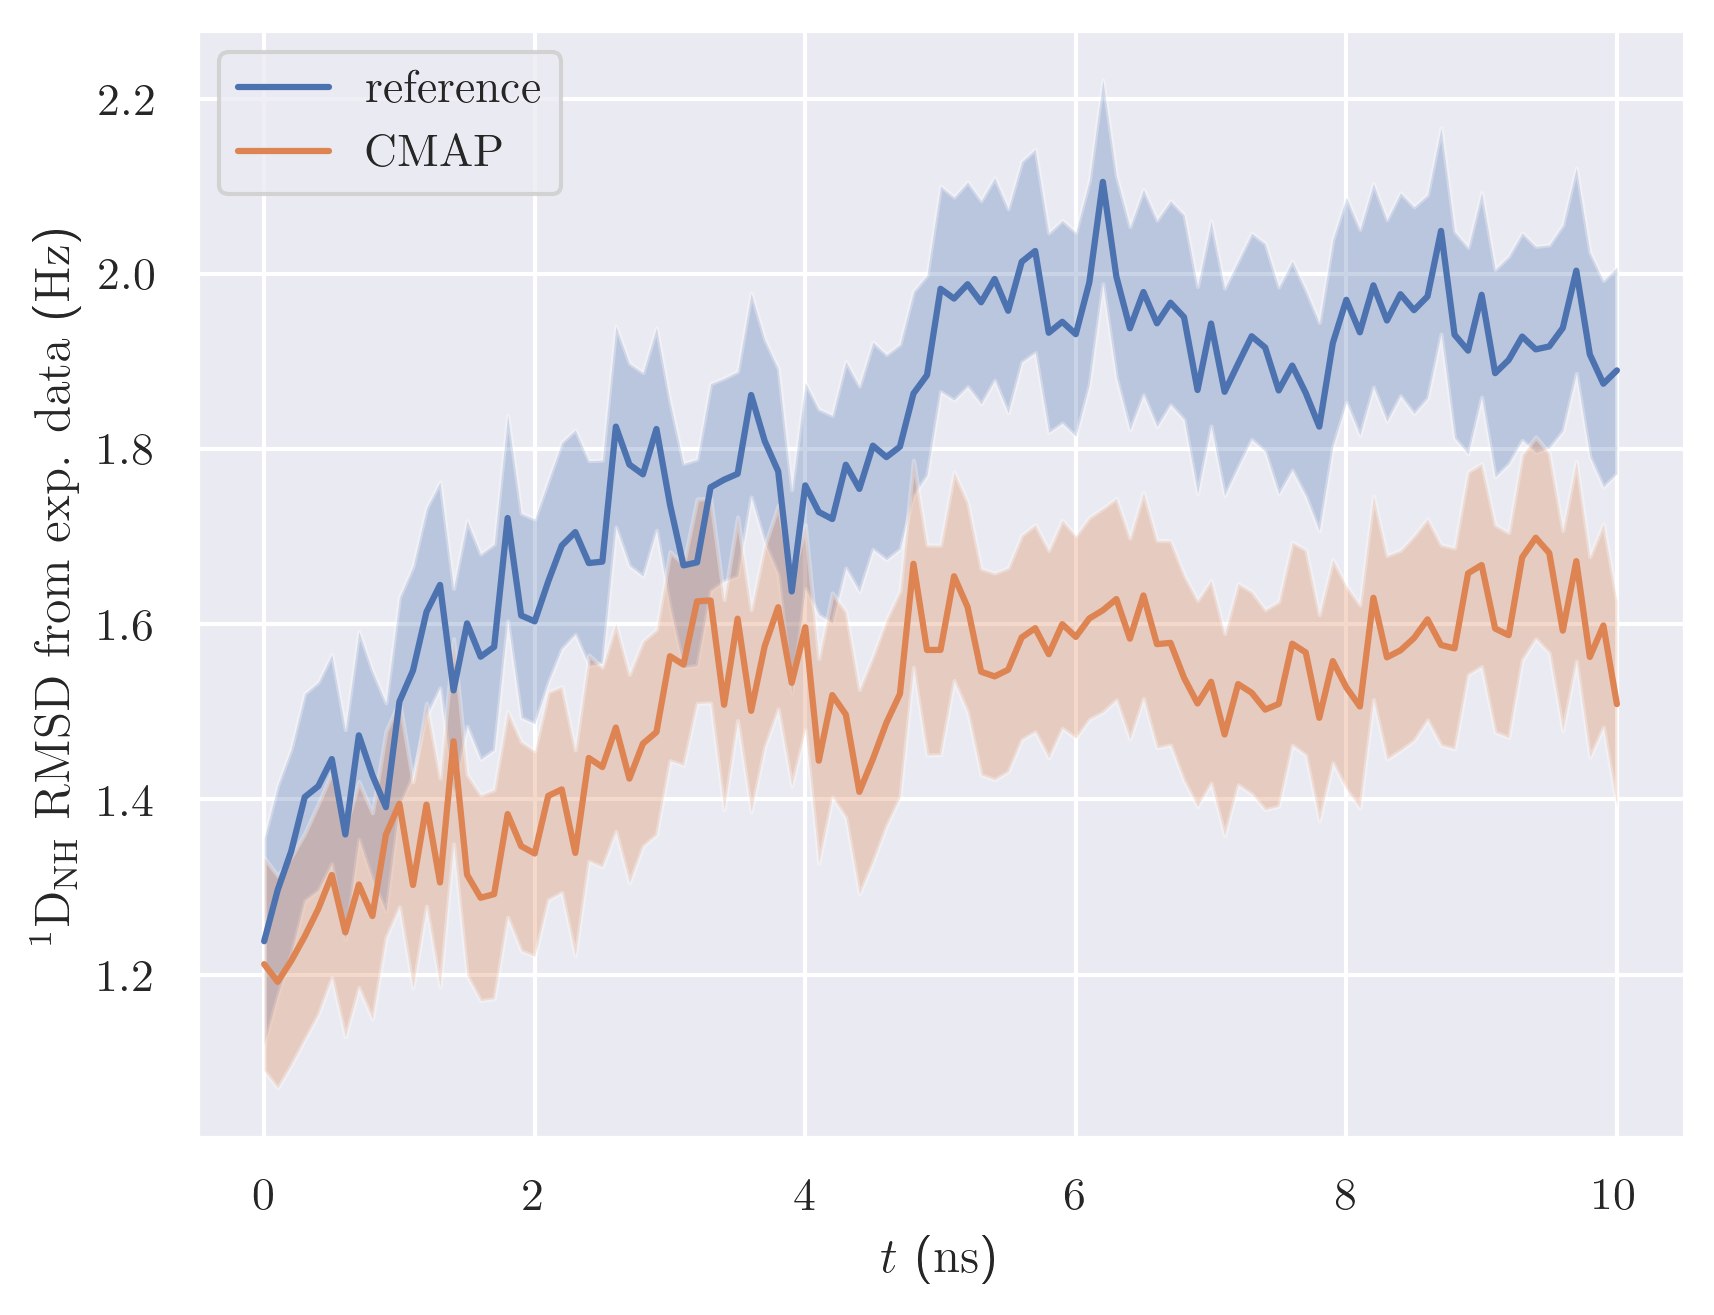

In [9]:
plt.figure(dpi=300)

ref_rmsd, ref_sigma = avg_rdc_rmsd(ref_rdc_df, exp_rdc)
cmap_rmsd, cmap_sigma = avg_rdc_rmsd(cmap_rdc_df, exp_rdc)

t = np.arange(ref_rmsd.size) / 10

plt.plot(t, ref_rmsd, label=r"\textrm{reference}")
plt.fill_between(t, ref_rmsd - ref_sigma, ref_rmsd + ref_sigma, alpha=0.3)

plt.plot(t, cmap_rmsd, label=r"\textrm{CMAP}")
plt.fill_between(t, cmap_rmsd - cmap_sigma, cmap_rmsd + cmap_sigma, alpha=0.3)

plt.xlabel(r"$t$ (\unit{\ns})")
plt.ylabel(r"${}^1\mathrm{D_{NH}}$ \textrm{RMSD from exp. data} (\unit{\Hz})")
plt.legend()